#### Imports

In [1]:
import torch
import torchvision

#### Preparing the hyper-parameters

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#### Getting the MNIST data from pyortch 

In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [16]:
import pandas as pd
import numpy as np

# transform train loader to pandas dataframe
train_data = []
for i, (data, target) in enumerate(train_loader):
    for j in range(len(data)):
        train_data.append([data[j].numpy().flatten(), target[j].numpy()])
        
train_df = pd.DataFrame(train_data, columns=['data', 'target'])

train_df

,data,target
0,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",1
1,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",1
2,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",1
3,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",5
4,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",3
...,...,...
59995,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",9
59996,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",7
59997,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",0
59998,"[-0.42421296, -0.42421296, -0.42421296, -0.424...",5


In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([1000, 1, 28, 28])

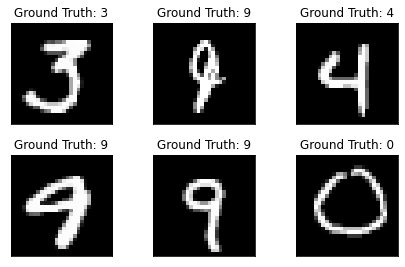

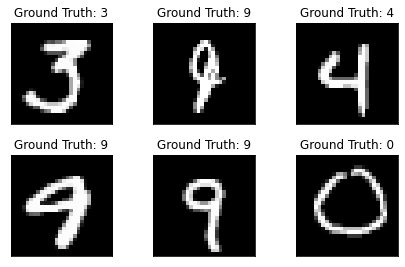

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './results/model.pth')
      torch.save(optimizer.state_dict(), './results/optimizer.pth')

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

C:\Users\badrg\AppData\Local\Temp\ipykernel_29000\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
c:\Users\badrg\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.011356
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.843857
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.758839
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.672644
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.687645
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.426628
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.284204
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.318824
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.445287
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.140658
Train Epoch: 1 [12160/6

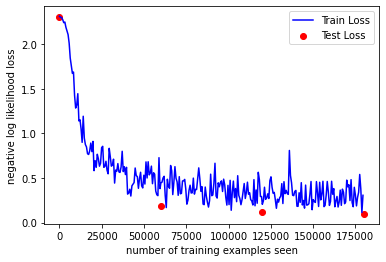

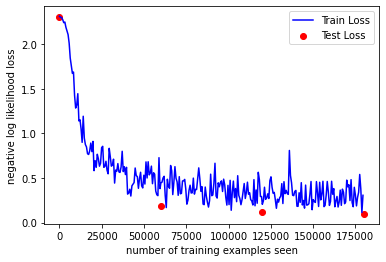

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [17]:
with torch.no_grad():
  output = network(example_data)

C:\Users\badrg\AppData\Local\Temp\ipykernel_29000\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


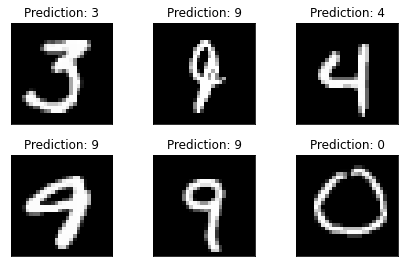

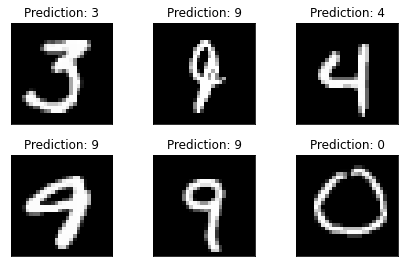

In [18]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [19]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [21]:
network_state_dict = torch.load("results/model.pth")
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load("results/optimizer.pth")
continued_optimizer.load_state_dict(optimizer_state_dict)

In [22]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

C:\Users\badrg\AppData\Local\Temp\ipykernel_29000\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.347863
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.113193
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.248571
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.153912
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.311286
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.279745
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.230949
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.235763
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.507043
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.154411
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.187590
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.209326
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.414583
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.118249
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.220262
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.266256
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.264274
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.224868
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.333900
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.288830
Train Epoch: 4 [12800/60000 (

c:\Users\badrg\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0817, Accuracy: 9738/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.083243
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.356721
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.197046
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.249328
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.250227
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.231926
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.281345
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.516328
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.284264
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.127160
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.182842
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.229620
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.139475
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.259903
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.330096
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.344567
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.275346
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.194398
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.379823
Train Epoch: 5 [12160

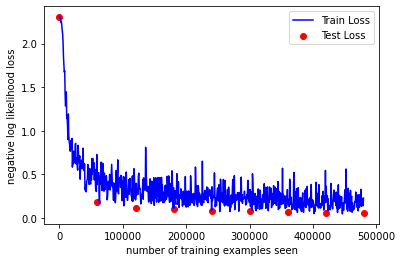

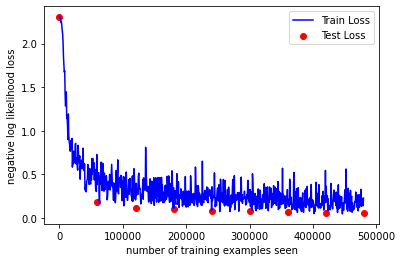

In [23]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [26]:
# make predictions data set with image id and prediction for all data in test_loader and train_loader and save to csv
predictions = []
for i, (data, target) in enumerate(test_loader):
    output = network(data)
    for j in range(len(data)):
        predictions.append([i*batch_size_test+j, output.data.max(1, keepdim=True)[1][j].item()])
        
for i, (data, target) in enumerate(train_loader):
    output = network(data)
    for j in range(len(data)):
        predictions.append([i*batch_size_train+j, output.data.max(1, keepdim=True)[1][j].item()])
        
predictions_df = pd.DataFrame(predictions, columns=['ImageId', 'Label'])
predictions_df.to_csv('results/predictions.csv', index=False)

C:\Users\badrg\AppData\Local\Temp\ipykernel_29000\161431047.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [27]:
test_data = pd.read_csv("./data/test.csv")

In [28]:
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
make_prediction